<a href="https://colab.research.google.com/github/vanderbilt-data-science/foundational_MMA_workshop/blob/main/PEFT_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter-Efficient Fine-Tuning (PEFT) Methods: **LoRA**

Parameter Efficient Fine Tuning (PEFT) refers to a suite of techniques used to fine tune models in more efficient, "scrappier" ways. The core insight behind these methods is that models normally can have their behaviors adjusted by adjusting a **much, much smaller** subset of parameters than traditional fine tuning.

In this notebook, we'll dive deep into one of the most important parameter-efficient fine-tuning techniques for large transformer-based models, LoRA (Low-Rank Adaptation), understanding both the theoretical foundation and practical implementation.

------

#### Why do we need PEFT?
In a typical fine-tuning paradigm, we would update all parameters of a pre-trained model. For a 7B parameter model like Llama-2 for instance, this would mean storing gradients and optimizer states for *all 7 billion parameters* - requiring massive GPU memory and computational resources that most practitioners simply don't have access to.

PEFT methods solve this by updating only a small subset of parameters (often <1% of the total!) - yet they still achieve performance comparable to full fine-tuning. These methods take advantage of the fact that most of a large model's knowledge and capability **doesn't** need to be changed or adjusted to adapt to new tasks.

PEFT is an umbrella term, and lots of different specific methods are different ways of doing parameter efficient fine tuning. In this notebook, we'll go in depth on one of the most commonly used methods:

- **Low-Rank Adaptation (LoRA)** - The foundation of modern PEFT that uses matrix decomposition

Other popular methods of parameter efficient fine tuning include:
- **Weight-Decomposed Low-Rank Adaptation (DoRA)** - A more sophisticated approach that separates magnitude and direction
- **Adapter Methods** - The original PEFT approach using small bottleneck layers

##**Basic Setup**

Let's start by preparing everything we'll need to run the code in this notebook.

### **Installs + Imports**

We'll set this up to run on Google Colab, which will need some additional installs. Below, we also import all packages needed for this code.

In [15]:
# Core ML libraries
!pip install -q transformers>=4.35.0
!pip install -q accelerate>=0.24.0
!pip install -q datasets>=2.14.0

# PEFT libraries - we'll use the official PEFT library and also implement from scratch
!pip install -q peft>=0.7.0
!pip install -q bitsandbytes>=0.41.0  # For efficient quantization if needed

# Visualization and analysis
!pip install -q matplotlib seaborn
!pip install -q plotly  # For interactive plots

# Optional: for more advanced examples
!pip install -q wandb  # For experiment tracking (optional)

In [16]:
# Now let's import everything we'll need
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel
)
from datasets import Dataset
import math
from typing import Optional, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')

In [17]:
# Check if we have CUDA available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


🔧 Using device: cpu


## **The Background**
LoRA is based on a simple but powerful insight: when we fine-tune a pre-trained model, the weight updates often have low "intrinsic rank".

That is to say, how many independent directions of change are actually meaningful in any given update matrix $\Delta W = W_{fine-tuned} - W_{original}$ is small. Even when $\Delta W$ might be a huge matrix (say 4096×4096), most of the meaningful changes during fine tuning are captured by much fewer dimensions.

----

So, where did this idea come from?



#### 1. **Prior Theoretical Work on Intrinsic Dimensionality**
Before LoRA, several papers established that neural networks often have much lower "intrinsic dimensionality" than their parameter count suggests. In particular, **Li et al. (2018)** and **Aghajanyan et al. (2020)** both invesigated training smaller subspaces of these models and found success adapting models therein, showing that the *effective* number of parameters needed for adaptation might be much smaller than the total parameter count.

#### 2. **The Key Empirical Discovery**
The LoRA authors **(Hu et al., 2021)** took this insight and attempted to measure the intrinsic rank of the weight updates during fine-tuning.

To do this, they:
- Fine-tuned GPT-3 on various tasks using full fine-tuning
- Computed the weight update matrices $\Delta W = W_{fine-tuned} - W_{original}$
- Performed Singular Value Decomposition (SVD) on these update matrices and analyzed how the values were distributed

#### 3. **The Findings**
What they found was that the weight update matrices had **very low effective ranks.** In fact,

- Most singular values were tiny (close to zero)
- Only a small number of singular values (often < 100) contained most of the "signal"

(And it held across different model sizes, tasks, and layers)

This result wasn't mathematically guaranteed nor obvious. Fine-tuning could theoretically require complex, high-dimensional change. And while over-parameterization suggested *some* redundancy, it was not known that that fine-tuning updates would be *universally* low-rank in a task, model, and optimization-independent way.

#### **The Mathematical Intuition**

Of course, there are several fundamental reasons why this low-rank structure might emerge and make good mathematical sense.

##### **1. _The Over-Parameterization Hypothesis_**
It's been hypothesized that large language models are massively over-parameterized for any *single* task. This over-parameterization means that many parameters are redundant for the specific adaptation task, and changes to different parameters become highly correlated.

##### **2. _Feature Reuse and Composition_**
Pre-trained models already contain rich, hierarchical feature representations. So fine-tuning typically can just rely on:

- **Reweighting existing features** rather than learning new ones from scratch
- **Combining existing patterns** in new ways rather than creating entirely new patterns
- **Adjusting decision boundaries** rather than learning new feature detectors

This also means adaptations can be expressed as linear combinations of *existing* feature directions.

##### **3. _Task Similarity_**
Most fine-tuning tasks share underlying structure with the pre-training objective. For instance, any new language task will involve:

- language understanding and generation
- use of common syntactic and semantic patterns

The main difference is often in *style* or *domain* rather than fundamental capabilities, so the adaptation primarily involves adjusting the "mixing weights" of existing capabilities rather than learning entirely new ones.

##### **4. _Gradient Flow and Optimization Dynamics_**
During fine-tuning, gradients tend to flow along the directions that were already "activated" during pre-training, meaning that:

1. Parameters that were important for pre-training are more likely to be updated
2. Updates tend to be correlated across layers (if one layer needs to change, related layers need complementary changes)

This type of optimization will naturally find low-dimensional paths through the parameter space.

### **The Core Mathematical Idea**

Now that we understand *why* updates might need to only be low-rank, let's talk about *how* we do low-rank updated in practice.

Instead of updating the full weight matrix $W \in \mathbb{R}^{d \times k}$ during fine-tuning, LoRA represents the update as:

$$h = W_0 x + \Delta W x = W_0 x + BA x$$

Here:
- $W_0$ is the original **frozen** pre-trained weight matrix
- $B \in \mathbb{R}^{d \times r}$ and $A \in \mathbb{R}^{r \times k}$ are trainable **low-rank matrices**
- $r \ll \min(d,k)$ is the rank of these matrices (typically 1-256)
- $\Delta W = BA$ represents the low-rank update

> Remember, if B is a {4096 x 4} matrix, and A is a {4 x 4096} matrix (rank 4), the *size of the update* to W is still {4096 x 4096} !

---

With this update, the number of trainable parameters drops from $d \times k$ to $(d + k) \times r$

For a typical transformer layer with $d=k=4096$ and $r=64$, that means:
- **Full fine-tuning**: $4096 \times 4096 = 16.8M$ parameters
- **LoRA**: $(4096 + 4096) \times 64 = 524K$ parameters  

- -> 97% fewer parameters!

### **Initialization Strategy** (Critical!)

LoRA uses a specific initialization strategy that's crucial for training stability. Let's dive a little deeper into what this initialization is, and why it's so important for stable training.

**The Initialization:**
- Matrix $A$ is initialized with small random Gaussian values: $A \sim N(0, \sigma^2)$
- Matrix $B$ is initialized to **zero**: $B = 0$

This ensures $\Delta W = BA = 0$ at initialization, meaning that the model *starts* at its exact baseline performance. But at least one of them must be non-zero to start, or you'd never get any gradients.

**The scaling factor α/r:**

$$h = W_0 x + \frac{\alpha}{r} BA x$$

This scaling really serves to give us control over the magnitude: $\alpha$ lets you control how "strong" the adaptation is
   - $\alpha = 0$: No adaptation (just original model)
   - $\alpha >> r$: Strong adaptation (LoRA dominates)
   - $\alpha \approx r$: Balanced adaptation (most common)

So, we get more stable training because:
- Training starts with the proven pre-trained model behavior
- LoRA gradually "grows in" as B learns non-zero values
- The scaling prevents wild swings in model behavior early in training

## **Putting it into Practice**

Now, let's look at how we build LoRA into model training in a practical sense. Let's start by seeing what building a LoRA layer would look like.

In [18]:
class LoRALayer(nn.Module):
    """
    A Low-Rank Adaptation layer that can wrap any linear layer.

    This implementation shows the core LoRA concept:
    - Keep original weights frozen
    - Add low-rank adaptation via two smaller matrices
    - Apply scaling to control adaptation strength
    """

    def __init__(self,
                 original_layer: nn.Linear,
                 rank: int = 4,
                 alpha: float = 32.0,
                 dropout: float = 0.1):
        super().__init__()

        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank  # This is the α/r scaling factor

        # Get dimensions from the original layer
        in_features = original_layer.in_features
        out_features = original_layer.out_features

        # Freeze the original layer
        self.original_layer = original_layer
        for param in self.original_layer.parameters():
            param.requires_grad = False

        # Create the low-rank matrices A and B
        # A: (rank, in_features) - initialized with small random values
        # B: (out_features, rank) - initialized to zero
        self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.01)
        self.lora_B = nn.Parameter(torch.zeros(out_features, rank))

        # Optional dropout for regularization
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        # Original computation: W₀x
        original_output = self.original_layer(x)

        # LoRA computation: (α/r) * B * A * x
        # We compute this as: (α/r) * B * (A * x) for efficiency
        lora_output = self.dropout(x) @ self.lora_A.T  # (batch, rank)
        lora_output = lora_output @ self.lora_B.T      # (batch, out_features)
        lora_output = lora_output * self.scaling       # Apply α/r scaling

        # Combine: W₀x + (α/r)BAx
        return original_output + lora_output

    def get_delta_weights(self):
        """
        Returns the actual ΔW = (α/r)BA matrix for analysis
        """
        return self.scaling * (self.lora_B @ self.lora_A)

# Let's test this with a simple example
print("Creating a test linear layer and its LoRA version...")
print("=" *50)

# Original linear layer
original = nn.Linear(256, 256)
print(f"Original layer parameters: {sum(p.numel() for p in original.parameters()):,}")

# LoRA version
lora_layer = LoRALayer(original, rank=16, alpha=32)
trainable_params = sum(p.numel() for p in lora_layer.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in lora_layer.parameters())

# Let's see the actual matrices A and B
print("Matrix A shape (rank × in_features):", lora_layer.lora_A.shape)
print("Matrix B shape (out_features × rank):", lora_layer.lora_B.shape)

print(f"LoRA trainable parameters: {trainable_params:,}")
print(f"LoRA total parameters: {total_params:,}")
print(f"Parameter reduction: {(1 - trainable_params/total_params)*100:.1f}%")

# Test forward pass
x = torch.randn(256, 256)  # batch_size=32, input_dim=512
output = lora_layer(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Creating a test linear layer and its LoRA version...
Original layer parameters: 65,792
Matrix A shape (rank × in_features): torch.Size([16, 256])
Matrix B shape (out_features × rank): torch.Size([256, 16])
LoRA trainable parameters: 8,192
LoRA total parameters: 73,984
Parameter reduction: 88.9%
Input shape: torch.Size([256, 256])
Output shape: torch.Size([256, 256])


### **LoRA In Real Applications**

In practice, when training a model, you'd make use of something like the PEFT library from huggingface (https://huggingface.co/docs/peft/en/index), which allows you to just specify a simple LoRA configuration and apply it to a model you want to train, and it handles the rest for you!

---

#### **Choosing Your LoRA Config**

Given that, a lot of what you need to do is make decisons around the LoRA configuration that you'll use. One of the key choices there is what weights you'll apply LoRA to.

In a transformer layer, let's look at the candidates.

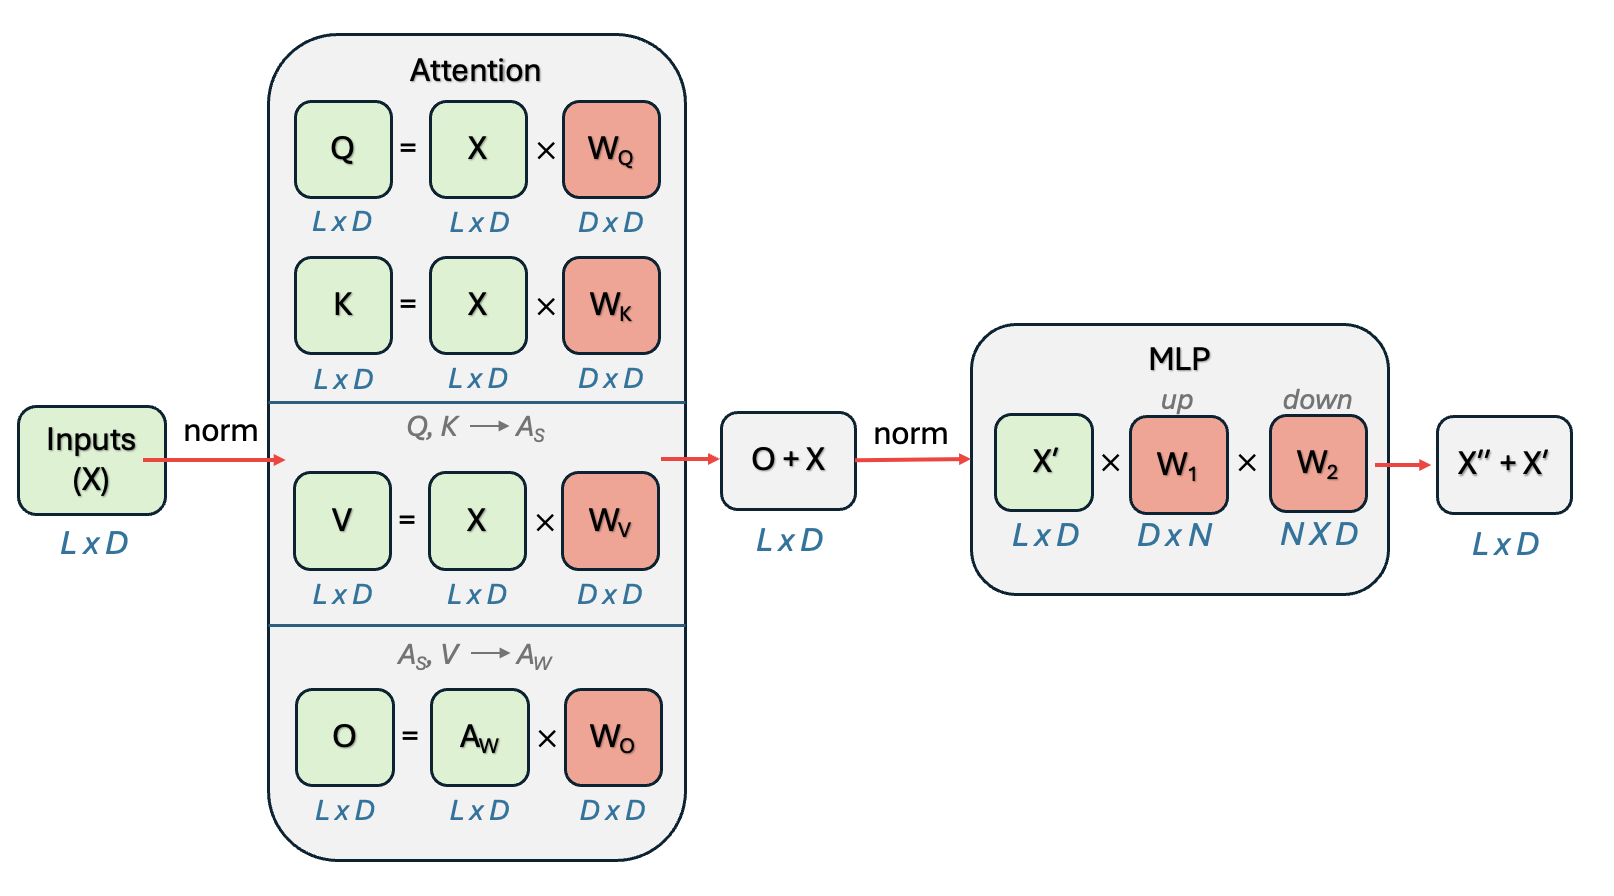

In [2]:
from IPython.display import Image as iImage, display
display(iImage("tutorial_images/transformer_layer_weights.png", width=1000))

LoRA is most typically applied to those weights that are part of the attention calculation (but we'll talk about that in more detail below).

The other thing to specify is the lora rank and alpha. For the example below, we'll choose those to be fairly stanard (16 and 32), but again, we discuss in more detail below what goes into making this choice.

In [19]:
# Let's load a small model for demonstration
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType

# Load a small model (we'll use a tiny one for demo purposes)
model_name = "distilgpt2"  # Small model that loads quickly
print(f"📦 Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Add padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Original model parameters: {model.num_parameters():,}")

# Configure LoRA - this is where you specify what we just implemented!
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # Type of task
    r=16,                          # Rank (our 'rank' parameter)
    lora_alpha=32,                 # Scaling factor (our 'alpha' parameter)
    lora_dropout=0.1,              # Dropout for regularization
    target_modules=["c_attn", "c_proj"],  # Which layers to apply LoRA to
    bias="none",                   # How to handle bias terms
)

# Apply LoRA to the model
lora_model = get_peft_model(model, lora_config)

# Check the parameter reduction
trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in lora_model.parameters())

# Show which modules were modified
print(f"\n🎯 LoRA was applied to these modules:")
lora_model.print_trainable_parameters()

📦 Loading distilgpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Original model parameters: 81,912,576

🎯 LoRA was applied to these modules:
trainable params: 811,008 || all params: 82,723,584 || trainable%: 0.9804


### **Choosing Parameters**

In a LoRA application, there are decisions to be made for the rank, alpha, layers to apply to, etc. So let's talk about how these are typically chosen.

---

#### **Which Layers?**

LoRA can theoretically be applied to any weight matrix in the model. But in practice, it's most typically applied to the weights of the matrices that make up the attention calculation. Studies have shown that seems to be where it's most useful, especially for task adaptations.

**MOST EFFECTIVE** (apply first):
- Query (`q_proj`) and Value (`v_proj`) projection matrices
- These capture the most important attention patterns
- Typically gives 80% of the benefit with minimal parameters

**OFTEN HELPFUL** (if you have more compute budget):
- Key projection (`k_proj`) matrices
- Output projection (`o_proj`) after attention  
- First linear layer in feed-forward networks

**SOMETIMES USEFUL** (advanced cases):
- Second feed-forward layer
- All linear layers (if you have lots of compute)

**USUALLY SKIPPED**:
- Embedding layers (too sensitive)
- Layer norms (few parameters anyway)
- Final classification heads (task-specific, need full updates)

---

#### **What Rank ($r$)**?

As a rule of thumb, the rank to choose for LoRA depends on the size of the weight matrices of the model, which normally depends on the number of parameters:
- Start with r=8-16 for small models (<1B params)
- Use r=16-64 for medium models (1B-10B params)
- Try r=64-256 for large models (>10B params)

Of course, task complexity also matters, with more complicated task adaptations often needing higher rank.

In general, a systematic approach, where you start small (r=8) and measure performance, doubling the rank until performance plateaus is one of the best ways to determine ideal rank. The "knee" of this curve is usually optimal.

---

#### **What Alpha ($\alpha$)?**

The $\alpha / r$ ratio matters, so usually the $\alpha$ is chosen with the additonal consideration of what this ratio would be, leading to:
- α/r = 1: Mild adaptation (good for similar tasks)
- α/r = 2: Standard adaptation (most common)
- α/r = 4+: Strong adaptation (very different tasks)

This means that typical $\alpha$ values are one of these multiples of rank. Most commonly, the desired $\alpha / r$ is chosen, then $\alpha$ adjusts based on the chosen rank. It's common to just keep $\alpha / r$ ~ 2, adjusting as r is changed.

---

#### **Other Important Settings**

The LoraConfig takes additional parameters that are commonly assigned, and some additional hyperparameters can help guide LoRA training.
1. **Dropout** can be used on the LoRA matrices, with typical values being low, 0.0-0.1 for stable tasks. Higher dropout can be used for more regularization.

2. **The Learning Rate** in fine tuning with LoRA can typically be ~10x higher than full fine-tuning.
- LoRA parameters start from zero, so they need stronger signal
- i.e you might try 1e-4 ~ 5e-4 for LoRA, vs 1e-5 for full fine-tuning